## Подготовка данных для экспертной оценки. Выбор модели

Чтобы создать базу для оценки качества работы модели, с заказчиком договорились, что его эксперт вручную даст оценку похожести по следующему принципу:

1. Эксперту предоставляется список пар запросов, которые изначально настроенная модель посчитала похожими
2. Эксперт выставляет каждой паре запросов свою оценку "похожи - не похожи"

Соответственно, качество работы модели оценивается по метрике Precision = TP / (TP + FP).

План действий:

1. Выбираем минимальную по возможностям модель с учетом требований нашей задачи и ограничений по ресурсам
2. Вычисляем эмбеддинги запросов
3. Выбираем запрос из архива случайным образом
4. Ищем для него наиболее похожий запрос на базе косинусного сходства
5. Многократно повторяем шаги 3-4
6. Предоставляем составленный список пар эксперту для оценки

Для удобства проведения экспертной оценки было создано вспомогательное приложение (см. отдельный проект validation_app).

Заказчик испытал затруднения при проставления бинарной оценки "похожи - не похожи" и предложил дать возможность ставить оценку в баллах от 0 до 9. Ну ок.

В итоге результат экспертной оценки будет иметь вид таблицы со следующими колонками:

- id1: идентификатор первого запроса
- id2: идентификатор второго запроса
- score_expert: оценка, выставленная экспертом

### Выбор модели для предварительной оценки похожести

Критерии выбора:
- поддержка русского, английского и латышского языков
- генерация текста не требуется, нужен только поиск похожих
- работа на локальном компьютере с оперативной памятью 32 Гб без GPU

Кандидаты:
- fasttext (использовали для похожей задачи на занятиях)
- модели с поддержкой русского и латышского с huggingface?

fasttext - понятный подход, построенный на принципах bag-of-words, но не будем же мы повторять пройденное. Посмотрим, можно ли с учетом имеющихся аппаратных ограничений решить задачу на более сложных моделях.

На huggingface по фильтру (ru & lv & en) & (размер < 6b) & (task = Sentence Similarity) & (поддержка pyTorch) найдено 24 модели.


In [2]:
import pandas as pd
pd.read_csv("../models/hf_models_ru_en_lv.csv").sort_values("Model", ascending=True)

,Group,Model,Size,Updated,Downloads
18,sartifyllc,African-Cross-Lingua-Embeddings-Model,0.5B,31.01.2025,231
22,setu4993,LEALLA-base,0.1B,19.10.2023,252
11,setu4993,LEALLA-large,0.1B,19.10.2023,46
10,setu4993,LEALLA-small,0.1B,19.10.2023,35
21,setu4993,LaBSE,0.5B,19.10.2023,6.98k
15,sentence-transformers,LaBSE,0.5B,06.03.2025,899k
23,Blaxzter,LaBSE-sentence-embeddings,0.5B,04.05.2023,46
3,onelevelstudio,M-E5-BASE,0.3B,19.03.2025,9
14,onelevelstudio,M-MPNET-BASE,0.3B,19.03.2025,7
13,onelevelstudio,ML-E5-0.3B,0.3B,26.03.2025,9


По принципу свежести и популярности - остановимся на paraphrase-multilingual и multilingual-e5.

Производительность моделей в различных вариантах поставки была проведена в отдельном ноутбуке model_benchmarks.

По итогам тестирования принято решение для начала экспериментов использовать e5-small.

In [3]:
MODEL_PATH = "intfloat/multilingual-e5-small" # также занесем в utils для дальнейшего использования

### Загрузка подготовленного ранее датафрейма

In [4]:
%run utils.ipynb # Вспомогательные функции

In [5]:
df = pd.read_parquet(DATA_DIR + "requests.parquet")
display(df.describe(include='all'))

,subject,id,details_filename,details,details_length,details_no_signs,details_no_signs_length,removed_blocks_count,details_no_signs_emails,details_no_signs_emails_length,...,request,request_length,request_initials,request_date,conversation,conversation_length,request_full,request_full_lentgth,language,lang_prob
count,12797,12797,12797,12797,12797.000000,12797,12797.000000,12797.000000,12797,12797.000000,...,12797,12797.000000,12797,12797,12797,12797.000000,12797,12797.000000,12797,12797.000000
unique,12242,12797,12797,12783,NaN,12780,NaN,NaN,12780,NaN,...,12555,NaN,500,3113,9302,NaN,12556,NaN,3,NaN
top,Lietotāja migrācija,CY-6793,CY-6793.txt,AKO - 14.05.2020\n\nДобрый день!\n\nЧерез 3 не...,NaN,ako - 14.05.2020 добрый день! через 3 недели и...,NaN,NaN,ako - 14.05.2020 добрый день! через 3 недели и...,NaN,...,"""",NaN,,,,NaN,"""",NaN,ru,NaN
freq,22,1,1,4,NaN,4,NaN,NaN,4,NaN,...,95,NaN,1807,1807,3453,NaN,95,NaN,5623,NaN
mean,NaN,NaN,NaN,NaN,2465.439947,NaN,2264.881691,0.305384,NaN,2123.322341,...,NaN,633.321560,NaN,NaN,NaN,1299.044620,NaN,783.768071,NaN,0.834649
std,NaN,NaN,NaN,NaN,8193.704091,NaN,7619.245209,1.152439,NaN,6047.435960,...,NaN,901.105117,NaN,NaN,NaN,4272.540675,NaN,4104.485427,NaN,0.219257
min,NaN,NaN,NaN,NaN,3.000000,NaN,1.000000,0.000000,NaN,1.000000,...,NaN,1.000000,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,0.074000
25%,NaN,NaN,NaN,NaN,499.000000,NaN,452.000000,0.000000,NaN,422.000000,...,NaN,145.000000,NaN,NaN,NaN,0.000000,NaN,145.000000,NaN,0.771000
50%,NaN,NaN,NaN,NaN,1105.000000,NaN,1003.000000,0.000000,NaN,943.000000,...,NaN,313.000000,NaN,NaN,NaN,314.000000,NaN,313.000000,NaN,0.941000
75%,NaN,NaN,NaN,NaN,2397.000000,NaN,2173.000000,0.000000,NaN,2052.000000,...,NaN,687.000000,NaN,NaN,NaN,1096.000000,NaN,687.000000,NaN,0.988000


Еще нам нужно соединить subject и request в один текст с нужным префиксом.

В частности, модели E5 требуют, чтобы к запросам был добавлен префикс 'query'.

In [6]:
def compose_e5_request(subject, details, prefix="query"):
    subject = (subject or "").strip()
    details = (details or "").strip()
    body = subject if details == "" else (subject + "\n" + details) if subject else details
    return f"{prefix}: {body}" if prefix else body

In [7]:
df["e5_request"] = df.apply(lambda row: compose_e5_request(row["subject"], row["request"], prefix="query"), axis=1)

In [8]:
df.to_parquet("../data/requests_with_e5.parquet", index=False)

### Анализ количества токенов в запросах

Согласно документации, модель обрабатывает до 512 токенов. Достаточно ли этого будет?

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def count_tokens(text):
    if not isinstance(text, str):
        return 0
    tokens = tokenizer.encode(text, add_special_tokens=True)
    return len(tokens)

Вычислим количество токенов в каждом запросе

In [10]:
df["n_tokens"] = df["e5_request"].progress_apply(count_tokens)
df["n_tokens"].describe()

100%|██████████| 12797/12797 [00:03<00:00, 3969.17it/s]


count    12797.000000
mean       199.348832
std        290.672057
min          6.000000
25%         54.000000
50%        100.000000
75%        206.000000
max       2617.000000
Name: n_tokens, dtype: float64

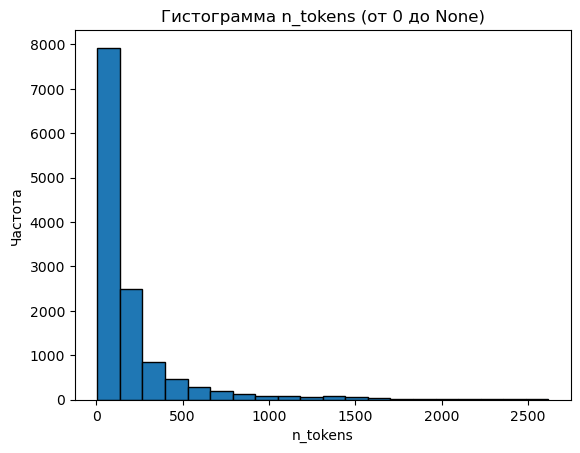

Показано значений: 12797 из 12797 (100.00%)
Ширина одного бина: 131


In [11]:
plot_hist(df, "n_tokens", bins=20)

In [12]:
print(f'Длина {(df["n_tokens"] <= 512).mean()*100:.2f}% запросов не превышает 512 токенов')

Длина 91.34% запросов не превышает 512 токенов


#### Выводы

Если не предпринимать никаких действий, то модель обработает 91% запросов полностью, остальные обрежет. Для начала такую стратегию и примем.

### Вычисление эмбеддингов

Перед вычислением был проведен дополнительный эксперимент, чтобы выяснить, будем ли использовать индекс FAISS. Решено не использовать, так как абсолютный выигрыш по времени (т.е. в долях секунд) на нашем датасете оказался несущественным. Даже если он в будущем вырастет в объеме в 10 раз.

Подробности см. в отдельном ноутбуке faiss_benchmark.

In [13]:
import numpy as np
from sentence_transformers import SentenceTransformer

def encode_requests(model, texts, backup_file="embeddings.npy"):

    embeddings = model.encode(
        texts,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True,
    ).astype(np.float32)

    if backup_file:
        np.save(DATA_DIR + "embeddings.npy", embeddings)

    return embeddings

In [14]:
model = SentenceTransformer(MODEL_PATH)

In [15]:
texts_sample = df["e5_request"].astype(str).tolist()
len(texts_sample)

12797

In [21]:
# embeddings = encode_requests(model, texts_sample) # закомментировано после однократного вычисления и сохранения эмбеддингов, чтобы не тратить время каждый раз, когда ноутбук приходится выполнять заново. Хотя заняло это всего 42 сек.


Batches:   0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
embeddings = np.load(DATA_DIR + "embeddings.npy")

In [26]:
embeddings.shape

(12797, 384)

In [27]:
import sys
print(sys.getsizeof(embeddings), "байт")

19656320 байт


Размер массива эмбеддингов 19 Мб - вполне допустимый.

### Поиск похожих запросов

#### А работает ли наша модель как мультиязычная?

Иными словами, будет ли она выдавать похожие запросы, если их язык отличается от исходного?

In [28]:
q = compose_e5_request("subj_sample", "details_sample") # как будут выглядеть новые запросы
q

'query: subj_sample\ndetails_sample'

In [29]:
q_emb = model.encode(q, convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
q_emb.shape

(384,)

In [30]:
scores = embeddings @ q_emb  # [N]
scores.shape

(12797,)

In [31]:
top_k_idx = np.argsort(scores)[::-1][:20] # сортируем индексы по убыванию значений, потом берем k первых
top_k_idx

array([ 4813,  9261,  8937,  7579,  7744, 12590, 12254,  3437,  4783,
       11805,  1437,  8751,  4688,   119,  9016,  7387,  5171,   374,
        3922, 12046])

In [32]:
result = df.iloc[top_k_idx][['id', 'language']].copy()
result['similarity'] = scores[top_k_idx]
result

,id,language,similarity
4813,IBM-9867,en,0.853363
9261,IBM-4444,en,0.850350
8937,IBM-4842,en,0.848571
7579,IBM-6442,en,0.847907
7744,IBM-6225,en,0.847670
12590,IBM-232,en,0.846951
12254,IBM-643,en,0.845983
3437,CY-367,en,0.845632
4783,IBM-9904,en,0.845093
11805,IBM-1271,en,0.844600


In [33]:
# Функция, которая ищет в датасете k похожих на запрос с заданным id, не включая этот запрос.
def find_similar_by_id(id, df, embeddings, top_k=20):

    # Находим индекс записи в df
    df_idx = df.index[df['id'] == id][0]

    # Эмбеддинг исходной записи
    q_emb = embeddings[df_idx]

    # Косинусные сходства (помним, что эмбеддинги нормированы, так что это просто @ )
    sims = embeddings @ q_emb  # (N,)

    # Обнуляем сходство с самим собой, чтобы не попал в top-k
    sims[df_idx] = -np.inf

    # Индексы top-k наиболее похожих
    top_k_idx = np.argsort(sims)[::-1][:top_k]

    # Формируем результирующую таблицу
    result = df.iloc[top_k_idx][['id', 'language']].copy()
    result['similarity'] = sims[top_k_idx]

    return result.reset_index(drop=True)

In [34]:
# Выбираем 100 случайных запросов, чтобы посмотреть, на каких языках модель будет находить похожие

random_ids = df.sample(n=100, random_state=1963)['id'].tolist()

# Список для хранения результатов
results = []

# Для каждого случайного запроса ищем наиболее похожий
for query_id in random_ids:
    # Получаем язык исходного запроса
    query_lang = df.loc[df['id'] == query_id, 'language'].iloc[0]

    # Ищем наиболее похожий (top_k=1)
    similar = find_similar_by_id(query_id, df, embeddings, top_k=1)

    # Добавляем результат
    results.append({
        'query_id': query_id,
        'query_lang': query_lang,
        'similar_id': similar['id'].iloc[0],
        'similar_lang': similar['language'].iloc[0],
        'similarity': similar['similarity'].iloc[0]
    })

# Создаем итоговую таблицу
results_df = pd.DataFrame(results)
display(results_df)

,query_id,query_lang,similar_id,similar_lang,similarity
0,IBM-163,en,IBM-746,en,0.910047
1,IBM-5814,lv,IBM-5392,lv,0.917913
2,IBM-5600,lv,IBM-5698,lv,0.951895
3,IBM-6807,ru,IBM-5717,ru,0.901601
4,IBM-6876,en,IBM-4574,ru,0.900727
...,...,...,...,...,...
95,CY-5439,en,CY-6593,en,0.895847
96,CY-2782,ru,CY-3077,ru,0.935435
97,IBM-7581,lv,IBM-2730,lv,0.911226
98,IBM-10393,en,CY-5645,en,0.915388


In [35]:
(results_df["query_lang"] == results_df["similar_lang"]).sum() # сколько пар с одинаковыми языками?

91

##### Выводы

Хотя модель и мультиязычная, но на первых позициях по похожести чаще всего выдает запросы на том же языке, что и исходный. Хотя другие языки тоже появляются в списке похожих.

### Создание списка пар запросов для экспертной оценки

Учитывая, что модель отдает предпочтение тому же языку, добавим в список не только top-1, но и ближайший из top-k на другом языке (если вообще есть среди похожих).

То есть подадим эксперту на оценку по каждому случайно отобранному запросу два похожих:
- первый - это самый top-1
- а если top-1 на том же языке, что и исходный запрос, то еще и ближайший в списке похожих на другом языке (если есть)

In [36]:
from tqdm import tqdm

# Формирует список n ближайших соседей на том же языке и ~n на другом.
def collect_similar_pairs(df, embeddings, n, top_k):

    ids = df["id"].astype(str).tolist() # все id
    langs = df["language"].astype(str).tolist() # языки, соответствующие id
    rng = np.random.default_rng(seed=1963) # инициализируем генератор сл.ч.

    pairs = [] # для результата
    seen = set() # множество пар, уже попавших в результат, чтобы искл. дубликаты

    for i_n in tqdm(rng.permutation(len(df))[:n], total=n): # цикл по n случайно выбранным индексам

        src_id = ids[i_n] # id1
        src_lang = langs[i_n] # его язык

        # Ближайшие соседи
        top_k_df = find_similar_by_id(src_id, df, embeddings, top_k)

        # Первый в списке, неважно на каком языке
        dst_id = top_k_df.iloc[0]["id"]
        score = top_k_df.iloc[0]["similarity"]
        dst_lang = top_k_df.iloc[0]["language"]
        key = tuple(sorted((src_id, dst_id))) # сортировка во избежание дубликатов
        if key not in seen:
            seen.add(key)
            pairs.append((src_id, dst_id, float(score), src_lang, dst_lang))

        # Ближайший на другом языке (если вообще есть в списке)
        for i_top_k in range(len(top_k_df)):

            dst_id = top_k_df.iloc[i_top_k]["id"]
            score = top_k_df.iloc[i_top_k]["similarity"]
            dst_lang = top_k_df.iloc[i_top_k]["language"]
            if dst_lang != src_lang:
                    key = tuple(sorted((src_id, dst_id)))
                    if key not in seen:
                        seen.add(key)
                        pairs.append((src_id, dst_id, float(score), src_lang, dst_lang))
                        break

    return pd.DataFrame(pairs, columns=["id1", "id2", "score_model", "lang1", "lang2"])




Сформируем наконец список для экспертной оценки.

Возьмем 500 исходных запросов, по каждому будем искать top-20 похожих.

По каждому исходному запросу в итоговый список добавим пару top-1, а также ближайшую пару на другом языке (если есть)

В итоге получим 500+ пар запросов для экспертной оценки.

Хотелось бы и больше, но больше чем 500 пар заказчик обработать точно не сможет. Будем реалистами.


In [37]:
pairs_df = collect_similar_pairs(df, embeddings, 500, 20)

100%|██████████| 500/500 [00:01<00:00, 275.54it/s]


Сохраним выбранные пары на будущее, вдруг пригодятся.

А эксперту (точнее, вспомогательному приложению) подадим на вход файл, содержащий только выбранные пары. Оценки модели для чистоты эксперимента эксперту будут недоступны.

Обратно вернутся эти же пары с оценками эксперта.

In [38]:
pairs_df.to_csv(DATA_DIR + "pairs_with_model_scores.csv", index=False)

In [39]:
out_df = pairs_df[["id1", "id2"]].copy()
out_df["score_expert"] = ""   # пустые значения
out_df.to_csv(DATA_DIR + "pairs_for_expert_scoring.csv", index=False)